# **E-commerce Customer Behavior Analysis** 
___

# `00` Import Dependencies

In [72]:
# Install Dependencies
# pip install yellowbrick pyspark kafka-python


In [73]:
# For Manipulation
import pandas as pd
import numpy as np
# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For pyspark usage
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# `01` Initialize Spark Session and Read Data

In [74]:
# Initializing Spark Session
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

In [75]:
# Loading The Dataset
customer_data = spark.read.csv("E-commerce Customer Behavior.csv", header=True, inferSchema=True)
customer_data.show(10)


+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|customer_id|gender|age|         city|membership_type|total_spend|items_purchased|average_rating|discount_applied|days_since_last_purchase|satisfaction_level|
+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|        101|Female| 29|     New York|           Gold|     1120.2|             14|           4.6|            true|                      25|         Satisfied|
|        102|  Male| 34|  Los Angeles|         Silver|      780.5|             11|           4.1|           false|                      18|           Neutral|
|        103|Female| 43|      Chicago|         Bronze|     510.75|              9|           3.4|            true|                      42|       Unsatisfied|
|        104|  Male| 30|San Francisco|        

# `02` Basic EDA

In [76]:
customer_data.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- membership_type: string (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- items_purchased: integer (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- discount_applied: boolean (nullable = true)
 |-- days_since_last_purchase: integer (nullable = true)
 |-- satisfaction_level: string (nullable = true)



In [77]:
customer_df = customer_data.toPandas()
customer_df.describe(include= 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,350.0,NaN,NaN,NaN,275.5,101.180532,101.0,188.25,275.5,362.75,450.0
gender,350,2,Female,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,350.0,NaN,NaN,NaN,33.597143,4.870882,26.0,30.0,32.5,37.0,43.0
city,350,6,New York,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
membership_type,350,3,Gold,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_spend,350.0,NaN,NaN,NaN,845.381714,362.058695,410.8,502.0,775.2,1160.6,1520.1
items_purchased,350.0,NaN,NaN,NaN,12.6,4.155984,7.0,9.0,12.0,15.0,21.0
average_rating,350.0,NaN,NaN,NaN,4.019143,0.580539,3.0,3.5,4.1,4.5,4.9
discount_applied,350,2,True,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_since_last_purchase,350.0,NaN,NaN,NaN,26.588571,13.440813,9.0,15.0,23.0,38.0,63.0


In [78]:
customer_df.isnull().sum()

customer_id                 0
gender                      0
age                         0
city                        0
membership_type             0
total_spend                 0
items_purchased             0
average_rating              0
discount_applied            0
days_since_last_purchase    0
satisfaction_level          2
dtype: int64


### Explore Categorical columns


In [79]:
customer_data.select(['gender']).distinct().show()

+------+
|gender|
+------+
|Female|
|  Male|
+------+



In [80]:
customer_data.select(['city']).distinct().show()


+-------------+
|         city|
+-------------+
|  Los Angeles|
|San Francisco|
|      Chicago|
|      Houston|
|        Miami|
|     New York|
+-------------+



In [81]:
customer_data.select(['membership_type']).distinct().show()

+---------------+
|membership_type|
+---------------+
|         Silver|
|           Gold|
|         Bronze|
+---------------+



In [82]:
customer_data.select(['satisfaction_level']).distinct().show()

+------------------+
|satisfaction_level|
+------------------+
|       Unsatisfied|
|         Satisfied|
|           Neutral|
|              NULL|
+------------------+



# `03` Comprehensive E-Commerce Customer Behavior Analysis

## Q1 : Can we segment customers based on their demographic information (Age, Gender, City) and shopping behaviors (Total Spend, Number of Items Purchased, Membership Type)

### **Customer Segmentation based on 'Membership', 'Age', 'City', and 'Item Purchased':**


In [83]:
# Create age groups
customer_df_age_groups = customer_data.withColumn("age Group",
                       when(customer_data["age"] < 35, "Under 35")
                       .when((customer_data["age"] >= 35) & (customer_data["age"] <= 50), "Between 35-50")
                       .otherwise("Over 50"))

# Group by Membership Type, Age Group, and City
customer_segments = customer_df_age_groups.groupBy("membership_type", "age Group", "city").agg({
    "total_spend": "mean",
    "items_purchased": "sum"
})

# Group by City separately
city_segments = customer_df_age_groups.groupBy("city").agg({
    "total_spend": "mean",
    "items_purchased": "sum"
})

# Show all segments in a single DataFrame
print('Customer Segmentation Result :  ')
customer_segments.show()

Customer Segmentation Result :  
+---------------+-------------+-------------+------------------+--------------------+
|membership_type|    age Group|         city|  avg(total_spend)|sum(items_purchased)|
+---------------+-------------+-------------+------------------+--------------------+
|         Silver|Between 35-50|  Los Angeles|            814.65|                 288|
|         Bronze|Between 35-50|      Chicago| 499.8827586206897|                 546|
|           Gold|     Under 35|     New York|1165.0355932203393|                 901|
|         Silver|     Under 35|  Los Angeles| 799.2114285714289|                 401|
|         Bronze|Between 35-50|      Houston|446.89482758620665|                 439|
|         Silver|     Under 35|        Miami| 690.3896551724141|                 675|
|           Gold|     Under 35|San Francisco|1460.4561403508774|                1141|
|           Gold|Between 35-50|San Francisco|            1420.8|                  19|
+---------------+----

### **Customer Segmentation based on 'City', and 'Item Purchased':**


In [84]:
# Show city segments separately
city_segments.show()

+-------------+------------------+--------------------+
|         city|  avg(total_spend)|sum(items_purchased)|
+-------------+------------------+--------------------+
|  Los Angeles| 805.4915254237288|                 689|
|San Francisco|1459.7724137931039|                1160|
|      Chicago| 499.8827586206897|                 546|
|      Houston|446.89482758620665|                 439|
|        Miami| 690.3896551724141|                 675|
|     New York|1165.0355932203393|                 901|
+-------------+------------------+--------------------+



### **Customer Segmentation based on 'Membership', 'City', and 'Item Purchased':**


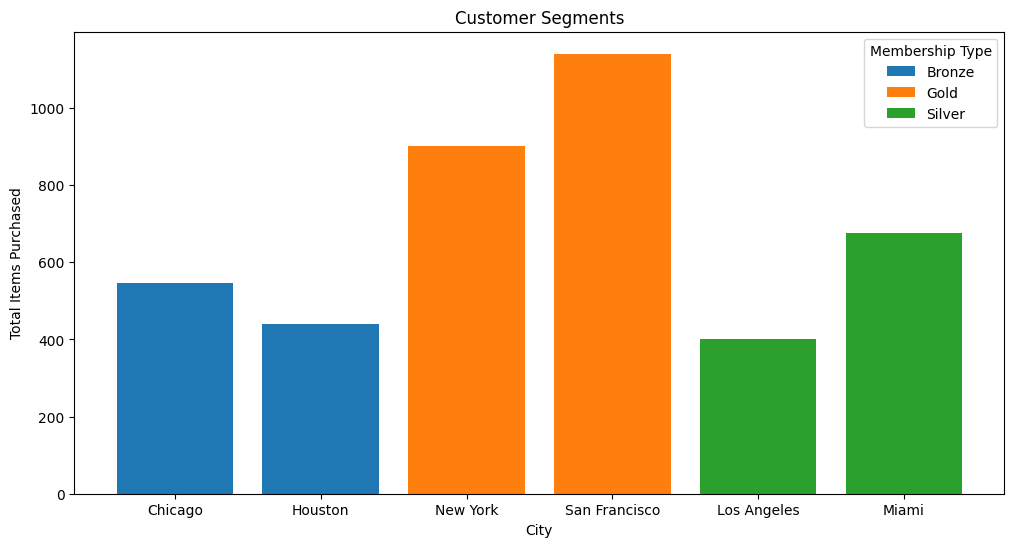

In [85]:
# Convert Spark DataFrame to Pandas DataFrame
customer_segments_pd = customer_segments.toPandas()

# Plot Customer Segments
plt.figure(figsize=(12, 6))
for membership_type, group in customer_segments_pd.groupby('membership_type'):
    plt.bar(group['city'] , group['sum(items_purchased)'], label=membership_type)
customer_df
plt.title('Customer Segments')
plt.xlabel('City')
plt.ylabel('Total Items Purchased')
plt.legend(title='Membership Type')
plt.show()

## **Customer Segmentation Analysis based on 'Membership', 'Age', 'City', and 'Item Purchased':**

#### ○ Gold Members (Under 35 in New York):

      • Exhibit the highest average total spending (1165.04) and a substantial sum of items purchased (901) and Indication a potentially 
       high-value and loyal customer segment.

#### ○ Silver Members (Under 35 in Los Angeles):

      • Show a considerable sum of items purchased (401) and a moderate average total spending (799.21).
      
#### ○ Bronze Members (Between 35-50 in Chicago):

      • Have a high sum of items purchased (546) but a relatively lower average total spending (499.88).
		


### Customer Segmentation based on their 'Membership Type', 'Total Spend', and 'Items Purchased' **Using Kmeans**. 

In [86]:
# split the columns we want to analyze
customer_seg_data = customer_data['membership_type', 'total_spend', 'items_purchased']
customer_seg_data.show(3)

# # Encoding 'membership_type'
customer_seg = customer_seg_data.replace(['Bronze', 'Silver', 'Gold'], ['0', '1', '2'], 'membership_type')
customer_seg = customer_seg.withColumn("membership_type", customer_seg['membership_type'].cast('integer'))

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=['membership_type', 'total_spend', 'items_purchased'],
                            outputCol="features")
customer_seg = assembler.transform(customer_seg)
customer_seg.show(3)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(customer_seg)
scaled_customer_seg = scaler_model.transform(customer_seg)
scaled_customer_seg.show(3)

+---------------+-----------+---------------+
|membership_type|total_spend|items_purchased|
+---------------+-----------+---------------+
|           Gold|     1120.2|             14|
|         Silver|      780.5|             11|
|         Bronze|     510.75|              9|
+---------------+-----------+---------------+
only showing top 3 rows

+---------------+-----------+---------------+-----------------+
|membership_type|total_spend|items_purchased|         features|
+---------------+-----------+---------------+-----------------+
|              2|     1120.2|             14|[2.0,1120.2,14.0]|
|              1|      780.5|             11| [1.0,780.5,11.0]|
|              0|     510.75|              9| [0.0,510.75,9.0]|
+---------------+-----------+---------------+-----------------+
only showing top 3 rows

+---------------+-----------+---------------+-----------------+--------------------+
|membership_type|total_spend|items_purchased|         features|     scaled_features|
+---------

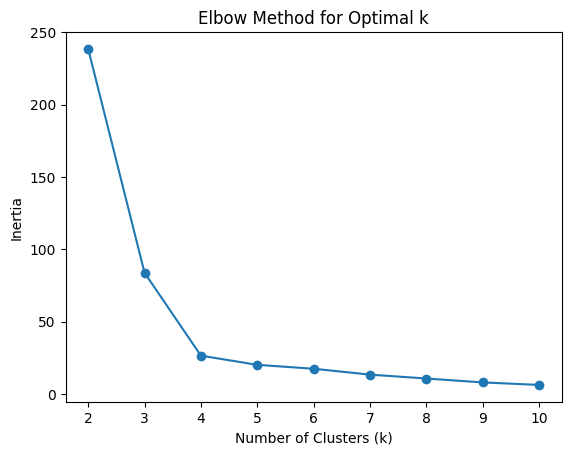

In [87]:
## Find the Best k splits for kmeans
# Calculate inertia for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(k=k)
    kmeans.setFeaturesCol("scaled_features")
    model = kmeans.fit(scaled_customer_seg)
    inertia.append(model.summary.trainingCost)

# Plot the inertia values
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [88]:

# Train KMeans model
kmeans = KMeans(featuresCol="scaled_features", k= 4, seed=42)  # I have tried 3 and 4, 4 is way higher in Silhouette score
# Make predictions
predictions = kmeans.fit(scaled_customer_seg).transform(scaled_customer_seg)

# Evaluate clustering performance
silhouette =  ClusteringEvaluator().evaluate(predictions)
print(f"Silhouette score: {silhouette}")

Silhouette score: 0.9409567254207083


In [89]:
cluster_distribution = predictions.select("prediction").toPandas()

# Count the occurrences of each cluster label and Rename clusters
cluster_distribution_counts = cluster_distribution["prediction"].value_counts().sort_index()
cluster_distribution_counts

prediction
0    117
1    116
2     59
3     58
Name: count, dtype: int64

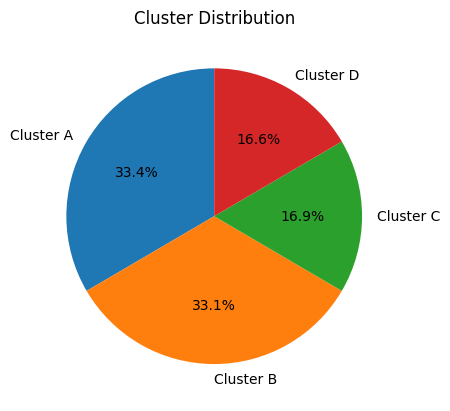


Cluster 0 Sample:

+---------------+-----------+---------------+
|membership_type|total_spend|items_purchased|
+---------------+-----------+---------------+
|              1|      780.5|             11|
|              1|      720.4|             13|
|              1|      800.9|             12|
|              1|      690.3|             11|
|              1|     820.75|             13|
+---------------+-----------+---------------+
only showing top 5 rows


Cluster 0 Information:

  summary membership_type        total_spend     items_purchased
0   count             117                117                 117
1    mean             1.0  748.4324786324781  11.658119658119658
2  stddev             0.0  60.59424951243999  1.1076722498757066
3     min               1              660.3                  10
4     max               1              830.9                  14

Cluster 1 Sample:

+---------------+-----------+---------------+
|membership_type|total_spend|items_purchased|
+-------------

In [90]:
class_names = ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D']

# Plot a pie chart
plt.pie(cluster_distribution_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Cluster Distribution')
plt.show()

# Print information related to each cluster
for cluster_label, count in cluster_distribution_counts.items():
    cluster_items = predictions.filter(predictions['prediction'] == cluster_label).select(['membership_type', 'total_spend', 'items_purchased'])
    cluster_info = cluster_items.describe().toPandas()
    print(f"\nCluster {cluster_label} Sample:\n")
    cluster_items.show(5)
    print(f"\nCluster {cluster_label} Information:\n")
    print(cluster_info)


## **Customer Segmentation Analysis based on 'Membership Type', 'Total Spend' and 'Items Purchased' :**

#### ○ Cluster 0:
    • Membership Type: All customers in this cluster have a membership type of 1.
    • Total Spend: The average total spend is approximately $748.43 with a standard deviation of $60.59.
    • Items Purchased: On average, customers in this cluster purchase around 11.66 items with a relatively low standard deviation.

#### ○ Cluster 1:
    • Membership Type: All customers in this cluster have a membership type of 0.
    • Total Spend: The average total spend is around $473.39 with a standard deviation of $31.30.
    • Items Purchased: On average, customers in this cluster purchase around 8.49 items with a standard deviation of 1.05.

#### ○ Cluster 2:
    • Membership Type: All customers in this cluster have a membership type of 2.
    • Total Spend: The average total spend is approximately $1165.04 with a standard deviation of $24.61.
    • Items Purchased: On average, customers in this cluster purchase around 15.27 items with a relatively low standard deviation.
    
#### ○ Cluster 3:
    • Membership Type: All customers in this cluster have a membership type of 2.
    • Total Spend: The average total spend is approximately $1459.77 with a standard deviation of $42.24.
    • Items Purchased: On average, customers in this cluster purchase 20 items with a standard deviation of 1.08.

## Q2 : Which customers are at risk of not making future purchases based on their Days Since Last Purchase and Satisfaction Level

In [91]:
# Filtering customers at risk based on Days Since Last Purchase and Satisfaction Level
at_risk_customers = customer_data.filter((customer_data["days_since_last_purchase"] > 30) & (customer_data["satisfaction_level"] == "Unsatisfied"))

# Show customers at risk
print('Customers at Risk Result : ')
at_risk_customers.show()

Customers at Risk Result : 
+-----------+------+---+-------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|customer_id|gender|age|   city|membership_type|total_spend|items_purchased|average_rating|discount_applied|days_since_last_purchase|satisfaction_level|
+-----------+------+---+-------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|        103|Female| 43|Chicago|         Bronze|     510.75|              9|           3.4|            true|                      42|       Unsatisfied|
|        105|  Male| 27|  Miami|         Silver|      720.4|             13|           4.0|            true|                      55|       Unsatisfied|
|        109|Female| 41|Chicago|         Bronze|     495.25|             10|           3.6|            true|                      40|       Unsatisfied|
|        111|  Male| 32|  Miami|         Silver|      

## **Customers Risk Analysis :**

• The result provides a list of customers who have not made a purchase within the duration ranges from **32 to 55 days and have expressed**                  dissatisfaction.

• The identified at-risk customers are primarily from the Bronze and Silver membership types.

• Indicates that customers with lower-tier memberships might be more prone to dissatisfaction.
	



# `04` Data Preprocessing

## Drop Nulls and Customer IDs

In [92]:
# Drop the "Customer ID" column
customer_data = customer_data.drop("customer_id")
# Handling missing values
customer_data = customer_data.na.drop()


## Encode Categorical Columns


In [93]:
# Define string columns to be encoded
string_cols = [col_name for col_name, data_type in customer_data.dtypes if data_type == "string"]
string_cols

['gender', 'city', 'membership_type', 'satisfaction_level']

In [94]:
# Fit StringIndexers on training set
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index", handleInvalid='skip').setHandleInvalid("keep") for col_name in string_cols]


In [95]:
# Apply transformations using transform method
numeric_cols = ['age', 'total_spend', 'items_purchased', 'discount_applied', 'average_rating', 'days_since_last_purchase']
assembler = VectorAssembler(inputCols=numeric_cols + [f"{col_name}_index" for col_name in string_cols], outputCol="features")

In [96]:
# scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

## Train and Test Split 


In [97]:
# Split the data into training and testing sets
trainDF, testDF = customer_data.randomSplit([.8, .2], seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

trainDF.show(2)

There are 295 rows in the training set, and 53 in the test set
+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|gender|age|    city|membership_type|total_spend|items_purchased|average_rating|discount_applied|days_since_last_purchase|satisfaction_level|
+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|Female| 29|   Miami|         Silver|      730.4|             14|           4.0|            true|                      50|       Unsatisfied|
|Female| 29|New York|           Gold|     1120.2|             14|           4.6|            true|                      25|         Satisfied|
+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
only showing top 2 rows



## Train the pipeline model using the trainig dataset

In [98]:
# Create a pipeline for simplicity
pipeline = Pipeline(stages=indexers + [assembler, scaler])
pipeline_model = pipeline.fit(trainDF)

In [99]:
# check the types after encoding
df_transformed_train = pipeline_model.transform(trainDF)
df_transformed_test = pipeline_model.transform(testDF)

df_transformed_train.show(5)

+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+------------+----------+---------------------+------------------------+--------------------+--------------------+
|gender|age|    city|membership_type|total_spend|items_purchased|average_rating|discount_applied|days_since_last_purchase|satisfaction_level|gender_index|city_index|membership_type_index|satisfaction_level_index|            features|     scaled_features|
+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+------------+----------+---------------------+------------------------+--------------------+--------------------+
|Female| 29|   Miami|         Silver|      730.4|             14|           4.0|            true|                      50|       Unsatisfied|         1.0|       0.0|                  0.0|                     0.0|[29.0,730.4,14.0,...|[5

In [100]:
# save the pipeline
pipeline_model.save('preprocessing_pipeline_model')

# `05` Model Pipeline Intialization
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

## Logistic regression classifier

In [101]:
#intialize the model
Logistic_model = LogisticRegression(featuresCol='scaled_features',
                                    labelCol='satisfaction_level_index',
                                    predictionCol='prediction').fit(df_transformed_train)

In [102]:
predictions = Logistic_model.transform(df_transformed_test)
predictions.select(['prediction', 'satisfaction_level_index']).filter(fn.col('satisfaction_level_index') == 1).show(3)

+----------+------------------------+
|prediction|satisfaction_level_index|
+----------+------------------------+
|       1.0|                     1.0|
|       1.0|                     1.0|
|       1.0|                     1.0|
+----------+------------------------+
only showing top 3 rows



# `06` Predection Model Evaluation

In [103]:
# Evaluate the accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="satisfaction_level_index", predictionCol="prediction", metricName="accuracy")
print("Test-set Accuracy is : ", evaluator.evaluate(predictions))

Test-set Accuracy is :  1.0


In [106]:
predictions.printSchema()


root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- membership_type: string (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- items_purchased: integer (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- discount_applied: boolean (nullable = true)
 |-- days_since_last_purchase: integer (nullable = true)
 |-- satisfaction_level: string (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- city_index: double (nullable = false)
 |-- membership_type_index: double (nullable = false)
 |-- satisfaction_level_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [109]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EcommerceDataAnalysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [110]:
filtered_predictions = predictions.filter(
    (col("prediction").isNotNull()) & (col("satisfaction_level_index").isNotNull())
)

# Convert to RDD and check the content
prediction_and_satisfaction = filtered_predictions.select("prediction", "satisfaction_level_index") \
    .rdd.map(lambda row: (float(row["prediction"]), float(row["satisfaction_level_index"])))

print(prediction_and_satisfaction.take(5))  # Check if the RDD contains data


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 867.0 failed 1 times, most recent failure: Lost task 0.0 in stage 867.0 (TID 740) (LAPTOP-5FOAR5GQ executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


Data seems to be a little bit perfect :D 

# `07` Isolation Forests For anomaly Detection

Why?

- It's an ensemble method based on decision trees and is efficient for detecting outliers.
- Does not assume any specific shape or distribution of the data.
- Can be adapted for streaming data by updating the existing forest as new data points arrive.
- It is relatively efficient and scalable for adding new data points.

In [113]:
from pyspark.sql import SparkSession

# Re-initialize Spark session with memory configurations
spark = SparkSession.builder \
    .appName("EcommerceDataAnalysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()


In [ ]:
from sklearn.ensemble import IsolationForest


# Extract feature vectors from the DataFrame
train_features = np.array(df_transformed_train.select('scaled_features').rdd.map(lambda x: x[0]).collect())
test_features = np.array(df_transformed_test.select('scaled_features').rdd.map(lambda x: x[0]).collect())



# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(random_state=42, contamination=0.05)
iso_model = iso_forest.fit(train_features)


In [ ]:
# Assuming iso_model.predict(test_features) returns a NumPy array
predictions = iso_model.predict(test_features)

# Find the indices where the value is -1 (anomalies)
anomaly_indices = np.where(predictions == -1)[0]

# Show the anomalies
df_transformed_test = df_transformed_test.toPandas()
df_transformed_test.iloc[anomaly_indices]


,gender,age,city,membership_type,total_spend,items_purchased,average_rating,discount_applied,days_since_last_purchase,satisfaction_level,gender_index,city_index,membership_type_index,satisfaction_level_index,features,scaled_features
20,Female,41,Chicago,Bronze,475.25,9,3.6,True,46,Unsatisfied,1.0,4.0,1.0,0.0,"[41.0, 475.25, 9.0, 1.0, 3.6, 46.0, 1.0, 4.0, ...","[8.365184605591091, 1.311911163220853, 2.14837..."
21,Female,41,Chicago,Bronze,475.25,9,3.6,True,48,Unsatisfied,1.0,4.0,1.0,0.0,"[41.0, 475.25, 9.0, 1.0, 3.6, 48.0, 1.0, 4.0, ...","[8.365184605591091, 1.311911163220853, 2.14837..."


In [ ]:
df_transformed_test.shape

(53, 16)

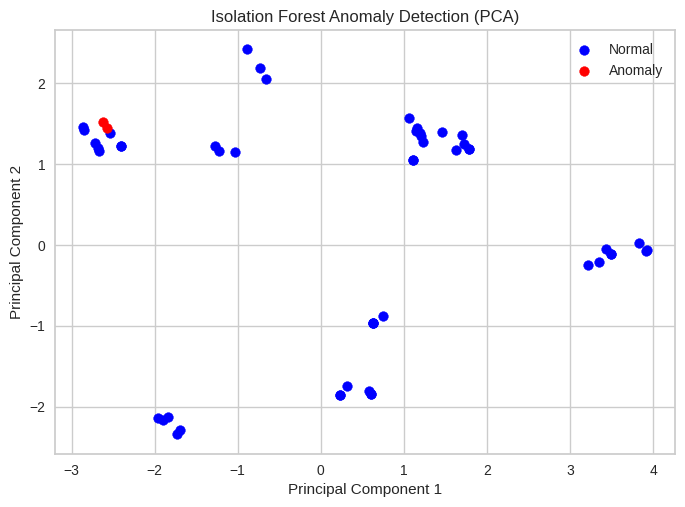

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on the training features
pca = PCA(n_components=2, random_state=42)
train_features_pca = pca.fit_transform(train_features)

# Project the test features onto the learned PCA space
test_features_pca = pca.transform(test_features)

# Get the predictions from the Isolation Forest model
predictions = iso_model.predict(test_features)

# Plot the normal data points
plt.scatter(test_features_pca[predictions == 1, 0], test_features_pca[predictions == 1, 1], c='blue', label='Normal')

# Plot the anomalies
plt.scatter(test_features_pca[predictions == -1, 0], test_features_pca[predictions == -1, 1], c='red', label='Anomaly')

plt.title('Isolation Forest Anomaly Detection (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [ ]:
# save the model 
from joblib import dump

dump(iso_model, './isolation_forest.joblib')